In [21]:
import datetime
import locale
import numpy as np
import pandas as pd
import os
import seaborn as sns

from matplotlib import dates
from matplotlib.lines import Line2D

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

locale.setlocale(locale.LC_ALL, "es_ES")
os.environ["TZ"] = "America/Santiago"

## Lectura de datos
En esta sección, obtenemos los datos del archivo `data.csv`. Los datos son actualizados de forma manual, a medida que las encuestas son presentadas al público.

In [22]:
data = pd.read_csv("data.csv")
data = data.sort_values("Fecha")
data["id"] = data["Fecha"] + "-" + data["Encuesta"]
data.head()

,Fecha,Fin_Recoleccion,Encuesta,Apruebo,Rechazo,NS/NC,N,Enlae,id
0,2022-03-04,NaN,Cadem,44.0,37.0,19.0,NaN,https://cadem.cl/estudios/con-la-informacion-d...,2022-03-04-Cadem
1,2022-03-11,NaN,Cadem,42.0,35.0,23.0,NaN,NaN,2022-03-11-Cadem
2,2022-03-20,NaN,Cadem,46.0,33.0,21.0,NaN,https://cadem.cl/estudios/plaza-publica-427-pr...,2022-03-20-Cadem
3,2022-03-20,NaN,Pulso Ciudadano,37.7,31.2,31.1,1004.0,https://chile.activasite.com/estudios/pulso-ci...,2022-03-20-Pulso Ciudadano
4,2022-03-25,NaN,Cadem,46.0,36.0,18.0,NaN,NaN,2022-03-25-Cadem


Asumimos que quienes respondieron **Apruebo** o **Rechazo** en la encuesta son equivalente a votos válidamente emitidos. En este sentido, recalculamos nuevos porcentajes para ambas variables, sin incluir No Sabe / No Contesta (NS/NC)

In [23]:
df = data.melt(id_vars=["Fecha", "Encuesta", "id"])
df = df[df["variable"].isin(["Apruebo", "Rechazo", "NS/NC"])]
df = df.groupby(["id", "Fecha", "Encuesta", "variable"]).agg({"value": "sum"})
df["rate"] = df.groupby(level=0).apply(lambda x: x/x.sum())
df = df.reset_index()

df["Fecha"] = pd.to_datetime(df["Fecha"])

In [24]:
start_date = datetime.datetime(2022, 4, 1)
today = datetime.datetime.today()

In [25]:
output = []
for dtDate in pd.date_range(start="2022-04-01", end=today):
    date = (dtDate - pd.DateOffset(days=21))
    df_tmp = df[(df["Fecha"] > date) & (df["Fecha"] <= dtDate)].copy()
    df_tmp["Fecha"] = dtDate
    output.append(df_tmp)

df_aggregated = pd.concat(output).reset_index()

Calculamos el porcentaje de **Apruebo** y **Rechazo** para el actual día donde se ejecutó el código.

In [26]:
df_stats = df_aggregated[df_aggregated["Fecha"] == df_aggregated["Fecha"].max()]\
    .groupby(["variable"])\
    .agg({"rate": "mean"}).reset_index()

## Visualización de datos

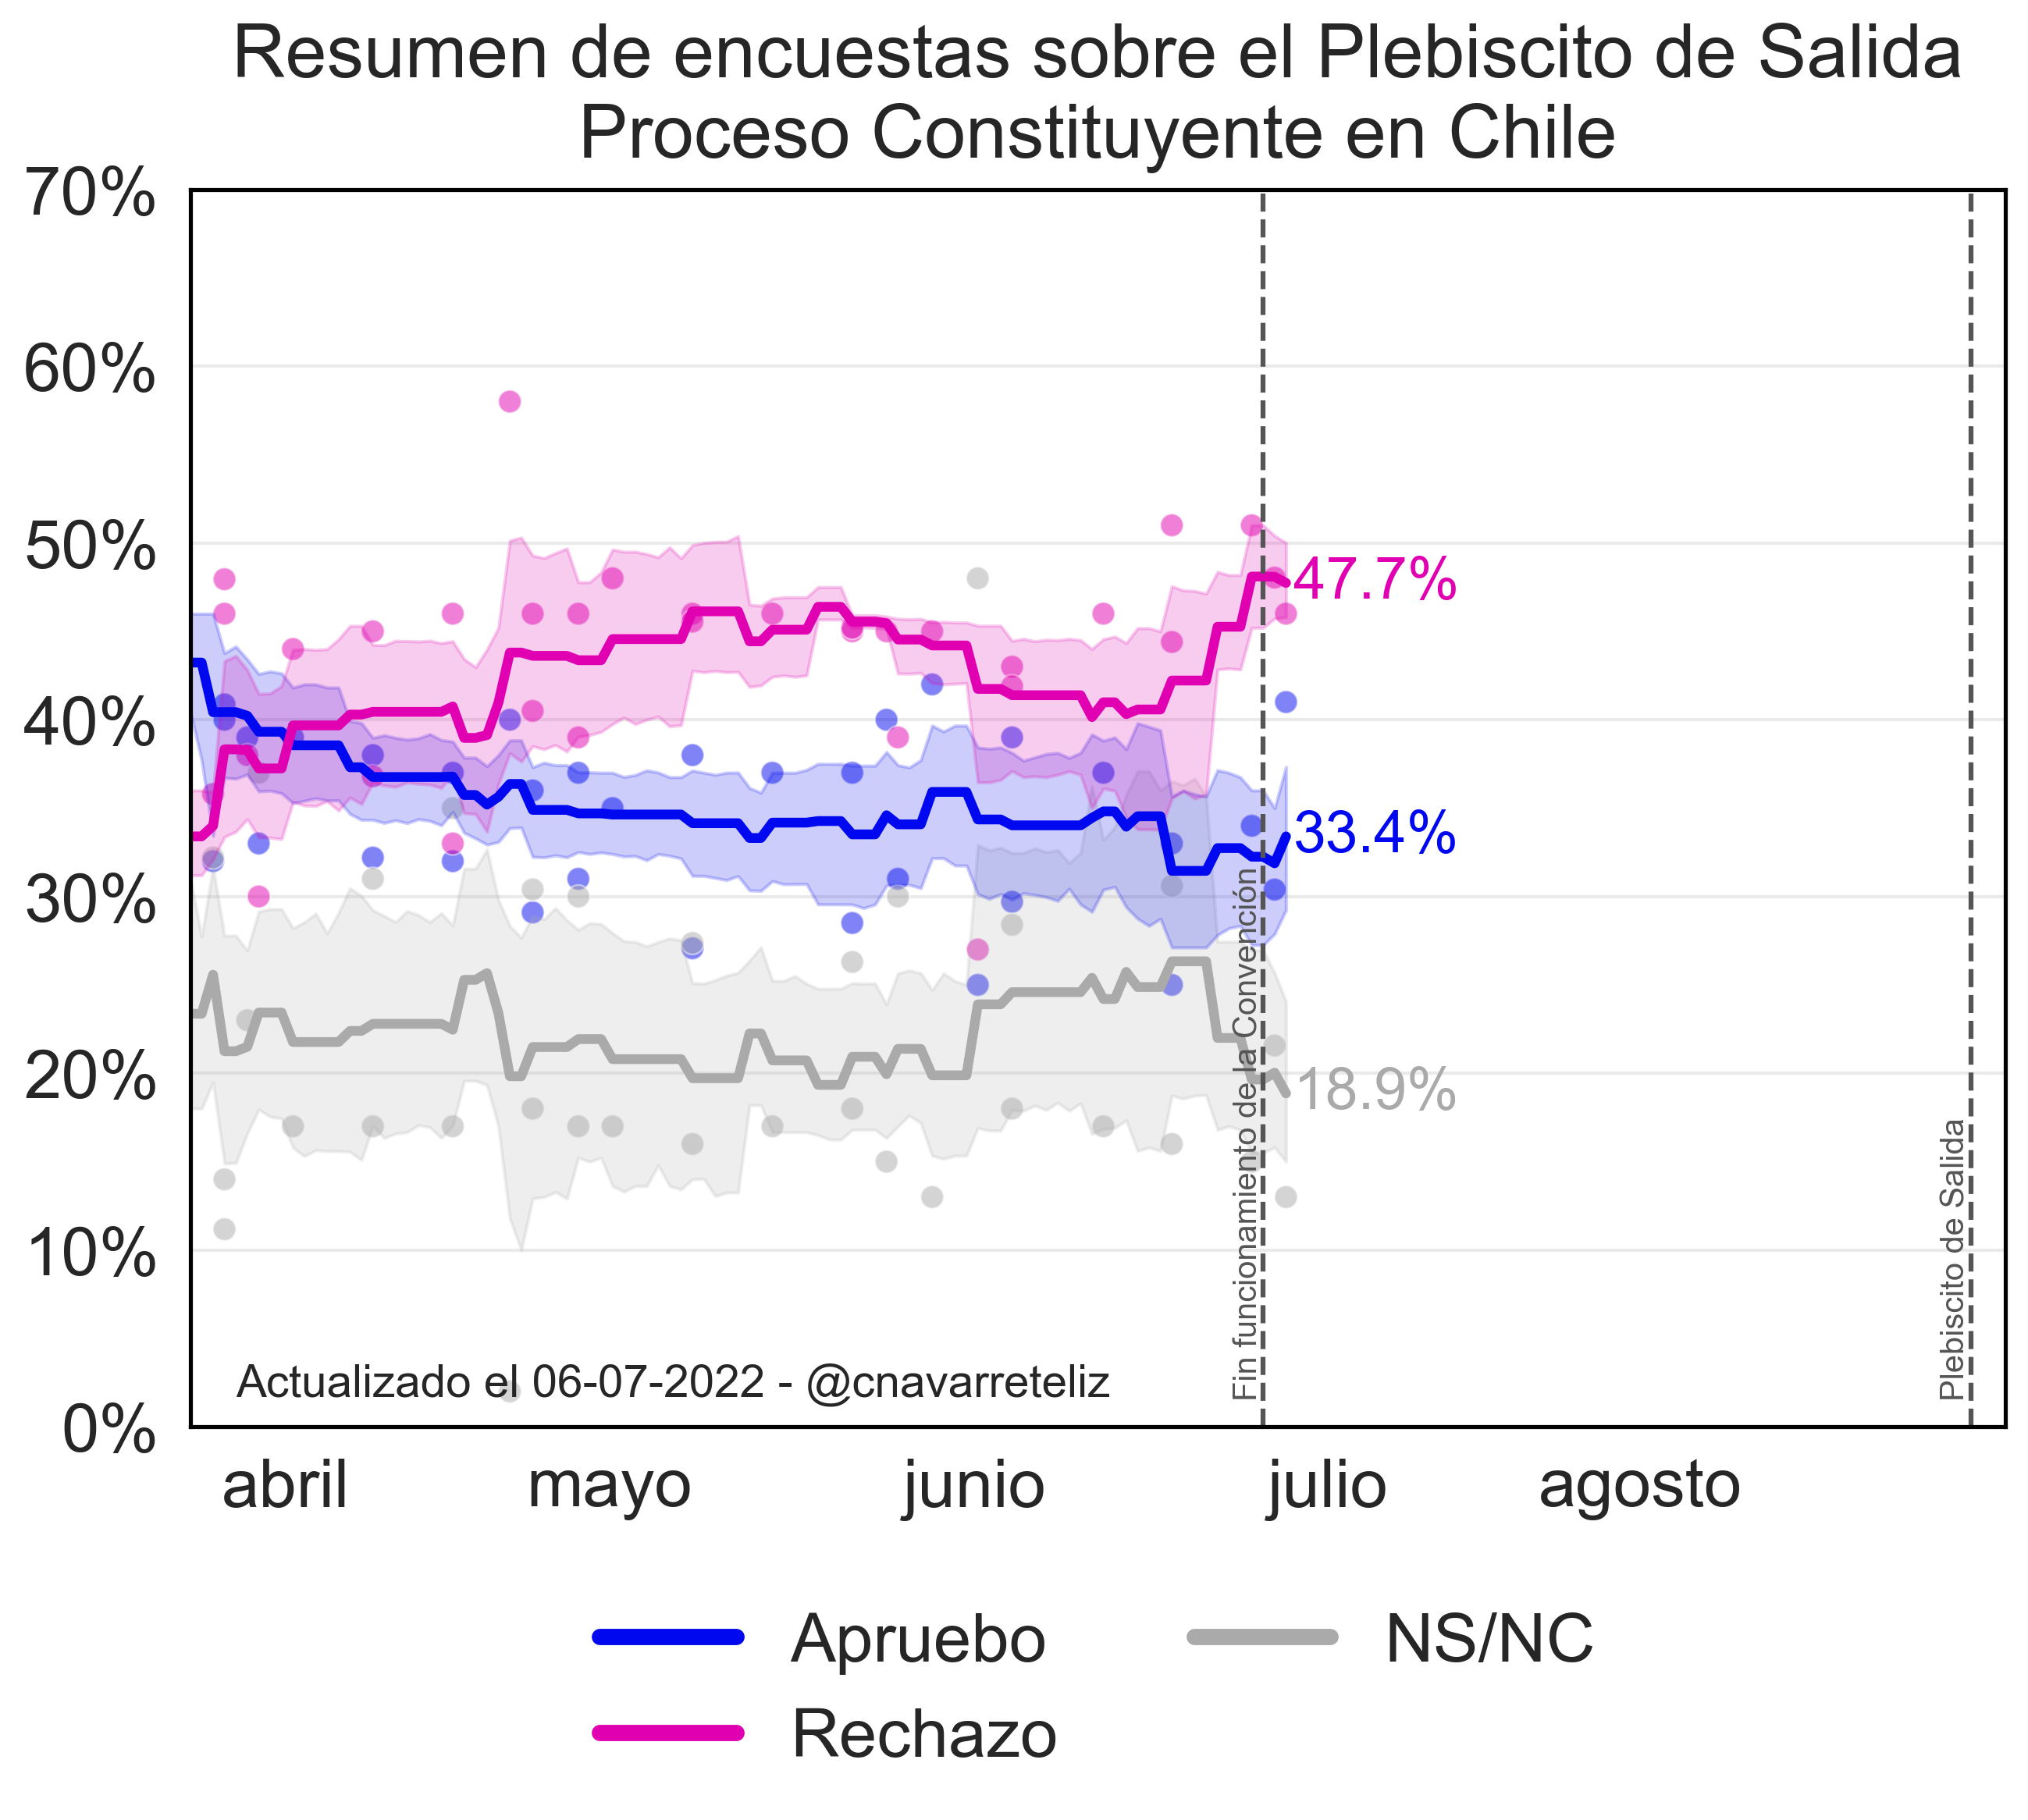

In [27]:
sns.set(font_scale=1.9, rc={"figure.figsize": (10, 7)}, style="whitegrid")

matplotlib.rc("axes", edgecolor="#000000")
matplotlib.rc("grid", color="#eaeaea")
plt.rcParams["font.family"] = "Arial"
plt.rcParams["svg.fonttype"] = "none"
matplotlib.rcParams["figure.dpi"] = 300

palette = ["#AAAAAA", "#0008EF", "#E000B1"]

g = sns.scatterplot(x="Fecha", y="rate", lw=0, alpha=0.5, palette=palette, hue="variable", s=50, 
                    data=df[df["Fecha"] >= start_date], hue_order=["NS/NC", "Apruebo", "Rechazo"])
g = sns.lineplot(x="Fecha", y="rate", palette=palette, hue_order=["NS/NC", "Apruebo", "Rechazo"], hue="variable", lw=3, data=df_aggregated)

deadline = datetime.datetime(2022, 7, 4)

gray_color = "#555555"
plt.axvline(deadline, linestyle="--", color=gray_color)
g.text(deadline, 0.015, "Fin funcionamiento de la Convención", color=gray_color, rotation=90, ha="right", fontsize=10, va="bottom")

deadline = datetime.datetime(2022, 9, 4)

gray_color = "#555555"
plt.axvline(deadline, linestyle="--", color=gray_color)
g.text(deadline, 0.015, "Plebiscito de Salida", color=gray_color, rotation=90, ha="right", fontsize=10, va="bottom")


g.text(0.025, 0.025, f"Actualizado el {today.strftime('%d-%m-%Y')} - @cnavarreteliz", transform=g.transAxes, fontsize=14)

for row in df_stats.itertuples():
    color = palette[1] if row.variable == "Apruebo" else palette[2] if row.variable == "Rechazo" else palette[0]
    g.text(today, row.rate, f"{np.round(row.rate * 100, 1)}%", color=color, fontsize=18, va="center")

def custom_ytick(x):
    tmp_tick = np.round(100 * x, 8)

    return f"{int(x * 100)}%" if tmp_tick.is_integer() else ""#f"{np.round(x * 100, 1)}%"
plt.ylim([0, 0.7])
fixed_list = g.get_yticks().tolist()

g.set_yticks(g.get_yticks())  # just get and reset whatever you already have
plt.gca().yaxis.set_ticklabels([custom_ytick(x) for x in fixed_list])

g.set_xlabel("")
g.set_ylabel("")

plt.gca().xaxis.set_major_formatter(dates.DateFormatter("%B"))
plt.gca().xaxis.set_major_locator(dates.MonthLocator(bymonthday=15))

for label in g.get_xmajorticklabels():
    label.set_rotation(0)
    label.set_horizontalalignment("right")

leg = g.legend()
leg.remove()

plt.gca().xaxis.grid(False)
plt.margins(x=0)

plt.xlim([start_date, datetime.datetime(2022, 9, 7)])


# Legend
legend_elements = [
    Line2D([0], [0], color=palette[1], label="Apruebo", lw=5),
    Line2D([0], [0], color=palette[2], label="Rechazo", lw=5),
    Line2D([0], [0], color=palette[0], label="NS/NC", lw=5)
]

g.legend(
    handles=legend_elements, 
    bbox_to_anchor=(0.5, -0.1),
    fancybox=False, 
    frameon=False, 
    loc="upper center", 
    ncol=2, 
    shadow=False
)

g.set_title("Resumen de encuestas sobre el Plebiscito de Salida\nProceso Constituyente en Chile", pad=10)

plt.show()